In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.io import imshow
from skimage.io import imread

import os
import cv2
import sys

from sklearn.model_selection import train_test_split
from google.colab import files

In [29]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [0]:
sys.path.append('/content/drive/My Drive')

In [0]:
from CycleGAN.models import *

In [7]:
!pip install visdom

    100% |████████████████████████████████| 1.4MB 13.5MB/s 
    100% |████████████████████████████████| 204kB 26.5MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


In [0]:
import argparse
import itertools

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch

from CycleGAN.models import Generator
from CycleGAN.models import Discriminator
from CycleGAN.utils import ReplayBuffer
from CycleGAN.utils import LambdaLR
from CycleGAN.utils import Logger
from CycleGAN.utils import weights_init_normal
from CycleGAN.datasets import ImageDataset

In [9]:
!ls "/content/drive/My Drive/"

'Colab Notebooks'       netD_A-8.pth    netD_B-9.pth	  netG_A2B.pth
 CycleGAN	        netD_A-9.pth    netD_B.pth	  netG_B2A-10.pth
 Datasets	        netD_A.pth      netG_A2B-10.pth   netG_B2A-11.pth
 list_attr_celeba.txt   netD_B-10.pth   netG_A2B-11.pth   netG_B2A-12.pth
 netD_A-10.pth	        netD_B-11.pth   netG_A2B-12.pth   netG_B2A-13.pth
 netD_A-11.pth	        netD_B-12.pth   netG_A2B-13.pth   netG_B2A-7.pth
 netD_A-12.pth	        netD_B-13.pth   netG_A2B-7.pth	  netG_B2A-8.pth
 netD_A-13.pth	        netD_B-7.pth    netG_A2B-8.pth	  netG_B2A-9.pth
 netD_A-7.pth	        netD_B-8.pth    netG_A2B-9.pth	  netG_B2A.pth


In [9]:
!ls "/content/drive/My Drive/Datasets/crop"

train_A  train_B


In [36]:
data = []
with open('/content/drive/My Drive/list_attr_celeba.txt', 'r') as f:
    for i, line in tqdm(enumerate(f)):
        data.append(line.strip().split())
        
celeb_attrs = pd.DataFrame(data[1:], columns=data[0])

train_files_A, test_files_A = train_test_split(celeb_attrs[celeb_attrs.Smiling == '1'].file_id.values, test_size=0.3)
train_files_B, test_files_B = train_test_split(celeb_attrs[celeb_attrs.Smiling != '1'].file_id.values, test_size=0.3)

202600it [00:01, 140364.71it/s]


In [0]:
train_files_A = ['./Datasets/img_celeba/' + x for x in train_files_A]
train_files_B = ['./Datasets/img_celeba/' + x for x in train_files_B]

In [7]:
len(celeb_attrs[celeb_attrs.Smiling == '1']), len(celeb_attrs[celeb_attrs.Smiling != '1'])

(97669, 104930)

In [0]:
# unzip train folder from google drive
!unzip /content/drive/My\ Drive/Datasets/train_A

In [9]:
!ls

drive  __MACOSX  sample_data  train_A  train_B


In [0]:
# move files to train and test folders
# import shutil
# for file_name in train_files_A:
#     shutil.move('./Datasets/img_celeba/' + file_name, './Datasets/train_A/' + file_name)
# for file_name in train_files_B:
#     shutil.move('./Datasets/img_celeba/' + file_name, './Datasets/train_B/' + file_name)

In [0]:
# get xmls for face detection and cropping
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml -P ./
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt.xml -P ./

In [0]:

def crop_faces_and_save(input_path, output_path):
  image_path = input_path

  def save_faces(cascade, imgname):
      img = cv2.imread(os.path.join(image_path, imgname))
      for i, face in enumerate(cascade.detectMultiScale(img)):
          x, y, w, h = face
          sub_face = img[y:y + h, x:x + w]
          cv2.imwrite(os.path.join(output_path, "{}".format(imgname)), sub_face)
          break


  face_cascade = "haarcascade_frontalface_default.xml"
  cascade = cv2.CascadeClassifier(face_cascade)
  # Iterate through files
  for i, f in enumerate([f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f))]):
      save_faces(cascade, f)
      if i % 500 == 0:
          print(i)
      if i > 3000:
          break

In [0]:
! mkdir cut
! chmod +x cut
! mkdir cut/train_A
! chmod +x cut/train_A
! mkdir cut/train_B
! chmod +x cut/train_B

In [9]:
! cp /content/drive/My\ Drive/Datasets/crop/train_A/* ./cut/train_A

^C


In [14]:
! ls /content/drive/My\ Drive/Datasets/crop/train_A/ | head -10

000161.jpg
000278.jpg
000384.jpg
000567.jpg
000629.jpg
000716.jpg
000744.jpg
000780.jpg
000810.jpg
001125.jpg


In [10]:
! cp /content/drive/My\ Drive/Datasets/crop/train_B/* ./cut/train_B

^C


In [20]:
crop_faces_and_save('train_A', 'cut/train_A')

0
500
1000
1500
2000
2500
3000


In [21]:
crop_faces_and_save('train_B', 'cut/train_B')

0
500
1000
1500
2000
2500
3000


In [52]:
! ls cut/train_A | head -10

000043.jpg
000161.jpg
000278.jpg
000384.jpg
000441.jpg
000475.jpg
000538.jpg
000567.jpg
000629.jpg
000716.jpg


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


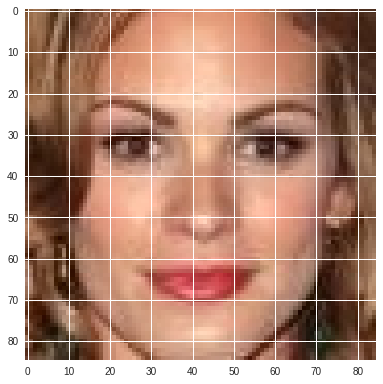

In [7]:
imshow('/content/drive/My Drive/Datasets/crop/train_A/000278.jpg')

In [0]:
class tmp():
    def __init__(self):
        self.epoch = 0
        self.n_epochs = 200
        self.batchSize = 1
        self.lr = 0.0002
        self.decay_epoch = 100
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cuda = True
        self.n_cpu = 8
        self.dataroot = '/content/drive/My Drive/Datasets/crop'
        
opt = tmp()

In [13]:
! ls /content/drive/My\ Drive/

'Colab Notebooks'   CycleGAN   Datasets   list_attr_celeba.txt


In [33]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

###### Definition of variables ######
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

# Load state dicts
generator_A2B = '/content/drive/My Drive/netG_A2B-13.pth'
generator_B2A = '/content/drive/My Drive/netG_B2A-13.pth'
discriminator_A = '/content/drive/My Drive/netD_A-13.pth'
discriminator_B = '/content/drive/My Drive/netD_B-13.pth'
netG_A2B.load_state_dict(torch.load(generator_A2B))
netG_B2A.load_state_dict(torch.load(generator_B2A))
netD_A.load_state_dict(torch.load(discriminator_A))
netD_B.load_state_dict(torch.load(discriminator_B))


if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

# netG_A2B.apply(weights_init_normal)
# netG_B2A.apply(weights_init_normal)
# netD_A.apply(weights_init_normal)
# netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

['/content/drive/My Drive/Datasets/crop/train_A/000161.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000278.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000384.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000567.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000629.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000716.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000744.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000780.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000810.jpg', '/content/drive/My Drive/Datasets/crop/train_A/001125.jpg']


In [0]:
from google.colab import files
import time
time.sleep(5)

In [0]:
# Loss plot
# logger = Logger(opt.n_epochs, len(dataloader))
###################################

###### Training ######
for epoch in range(14, opt.n_epochs):
    print('epoch = ', epoch)
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss
        # G_A2B(B) should equal B if real B is fed
        same_B = netG_A2B(real_B)
        loss_identity_B = criterion_identity(same_B, real_B)*5.0
        # G_B2A(A) should equal A if real A is fed
        same_A = netG_B2A(real_A)
        loss_identity_A = criterion_identity(same_A, real_A)*5.0

        # GAN loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle loss
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0

        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()
        
        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################

        # Progress report (http://localhost:8097)
        # logger.log({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
        #            'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)}, 
        #            images={'real_A': real_A, 'real_B': real_B, 'fake_A': fake_A, 'fake_B': fake_B})
        if i % 100 == 0:
          print({'loss_G': loss_G, 'loss_G_identity': (loss_identity_A + loss_identity_B), 'loss_G_GAN': (loss_GAN_A2B + loss_GAN_B2A),
                    'loss_G_cycle': (loss_cycle_ABA + loss_cycle_BAB), 'loss_D': (loss_D_A + loss_D_B)})

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), '/content/drive/My Drive/netG_A2B-%s.pth'%epoch)
    torch.save(netG_B2A.state_dict(), '/content/drive/My Drive/netG_B2A-%s.pth'%epoch)
    torch.save(netD_A.state_dict(), '/content/drive/My Drive/netD_A-%s.pth'%epoch)
    torch.save(netD_B.state_dict(), '/content/drive/My Drive/netD_B-%s.pth'%epoch)
    
#     files.download('netG_A2B.pth')
#     time.sleep(5)
#     files.download('netG_B2A.pth')
#     time.sleep(5)
#     files.download('netD_A.pth')
#     files.download('netD_B.pth')
###################################

epoch =  14
{'loss_G': tensor(2.7354, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_identity': tensor(0.6110, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_GAN': tensor(0.5468, device='cuda:0', grad_fn=<AddBackward0>), 'loss_G_cycle': tensor(1.5776, device='cuda:0', grad_fn=<AddBackward0>), 'loss_D': tensor(0.7465, device='cuda:0', grad_fn=<AddBackward0>)}


In [0]:
# files.download('netG_A2B.pth')
# files.download('netG_B2A.pth')
# files.download('netD_A.pth')
# files.download('netD_B.pth')

In [0]:
!cp ./netG_A2B.pth /content/drive/My\ Drive/
!cp ./netG_B2A.pth /content/drive/My\ Drive/
!cp ./netD_A.pth /content/drive/My\ Drive/
!cp ./netD_B.pth /content/drive/My\ Drive/

In [4]:
torch.save(netG_A2B.state_dict(), '/content/drive/My Drive/netG_A2B-%s.pth'%epoch)
torch.save(netG_B2A.state_dict(), '/content/drive/My Drive/netG_B2A-%s.pth'%epoch)
torch.save(netD_A.state_dict(), '/content/drive/My Drive/netD_A-%s.pth'%epoch)
torch.save(netD_B.state_dict(), '/content/drive/My Drive/netD_B-%s.pth'%epoch)

NameError: ignored

In [0]:
files.download('netG_A2B.pth')
# time.sleep(5)
# files.download('netG_B2A.pth')
# time.sleep(5)
# files.download('netD_A.pth')
# files.download('netD_B.pth')

In [0]:
# run in terminal for visualization
#! python -m visdom.server

In [0]:
# test

In [0]:
import sys
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

from CycleGAN.models import Generator
from CycleGAN.datasets import ImageDataset
from PIL import Image

In [0]:
class tmp():
    def __init__(self):
        self.batchSize = 1
        self.lr = 0.0002
        self.decay_epoch = 100
        self.size = 256
        self.input_nc = 3
        self.output_nc = 3
        self.cuda = False
        self.n_cpu = 8
        self.dataroot = '/content/drive/My Drive/Datasets/crop'
        self.generator_A2B = '/content/drive/My Drive/netG_A2B-13.pth'
        self.generator_B2A = '/content/drive/My Drive/netG_B2A-13.pth'

In [0]:
opt = tmp()

In [0]:
! mkdir A
! mkdir B
! chmod +x A
! chmod +x B

In [16]:
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()

# Load state dicts
netG_A2B.load_state_dict(torch.load(opt.generator_A2B))
netG_B2A.load_state_dict(torch.load(opt.generator_B2A))

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='train'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)
###################################

###### Testing######

# Create output dirs if they don't exist
# if not os.path.exists('output/A'):
#     os.makedirs('output/A')
# if not os.path.exists('output/B'):
#     os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, 'A/%04d.png' % (i+1))
    save_image(fake_B, 'B/%04d.png' % (i+1))
    print(i)

#     sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

# sys.stdout.write('\n')
###################################



['/content/drive/My Drive/Datasets/crop/train_A/000161.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000278.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000384.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000567.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000629.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000716.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000744.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000780.jpg', '/content/drive/My Drive/Datasets/crop/train_A/000810.jpg', '/content/drive/My Drive/Datasets/crop/train_A/001125.jpg']


KeyboardInterrupt: ignored

In [88]:
!ls A | head -10

0001.png
0002.png
0003.png
0004.png
0005.png
0006.png
0007.png
0008.png
0009.png
0010.png


In [94]:
!ls B

0001.png  0002.png


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


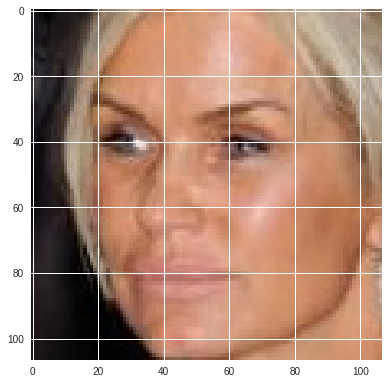

In [17]:
imshow('/content/drive/My Drive/Datasets/crop/train_B/001122.jpg')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


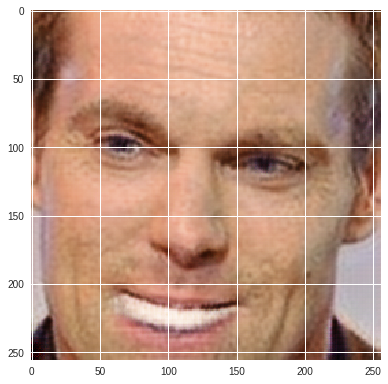

In [66]:
imshow('./A/0006.png')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


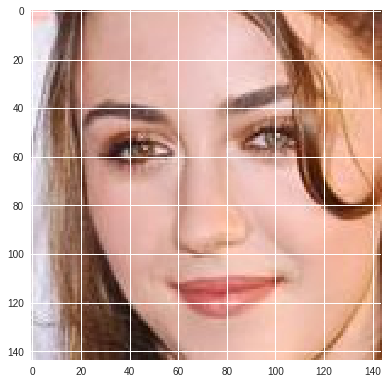

In [62]:
imshow('/content/drive/My Drive/Datasets/crop/train_B/001363.jpg')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


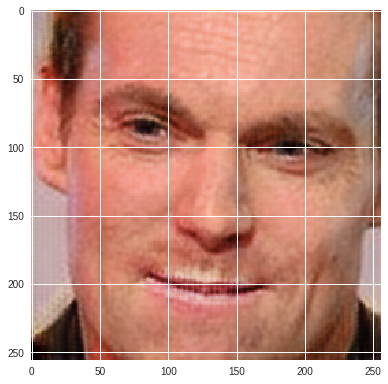

In [27]:
imshow('./A/0006.png')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


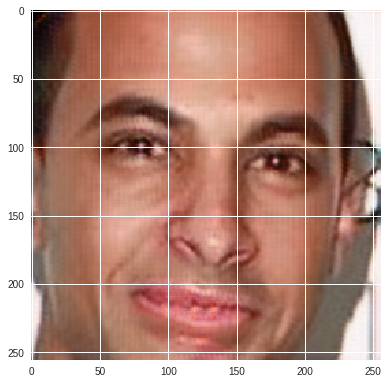

In [69]:
imshow('./B/0011.png')

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


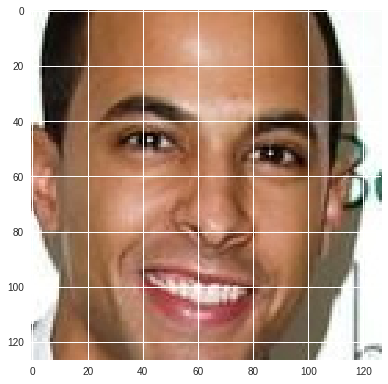

In [70]:
imshow('./cut/train_A/001217.jpg')

In [119]:
!ls /content/drive/My\ Drive/Datasets/crop/train_A/

000161.jpg  036081.jpg	070346.jpg  104600.jpg	136569.jpg  171117.jpg
000278.jpg  036245.jpg	070416.jpg  104605.jpg	136635.jpg  171220.jpg
000384.jpg  036454.jpg	070425.jpg  104674.jpg	136676.jpg  171289.jpg
000567.jpg  036470.jpg	070575.jpg  104683.jpg	136718.jpg  171359.jpg
000629.jpg  036495.jpg	070615.jpg  104756.jpg	136736.jpg  171362.jpg
000716.jpg  036600.jpg	070648.jpg  104900.jpg	136895.jpg  171396.jpg
000744.jpg  036707.jpg	070769.jpg  105012.jpg	136999.jpg  171444.jpg
000780.jpg  036750.jpg	070888.jpg  105027.jpg	137277.jpg  171719.jpg
000810.jpg  036825.jpg	070913.jpg  105051.jpg	137475.jpg  171762.jpg
001125.jpg  036983.jpg	071057.jpg  105057.jpg	137488.jpg  171773.jpg
001217.jpg  037011.jpg	071077.jpg  105174.jpg	137526.jpg  171912.jpg
001291.jpg  037041.jpg	071217.jpg  105266.jpg	137654.jpg  171952.jpg
001345.jpg  037361.jpg	071219.jpg  105329.jpg	137749.jpg  172065.jpg
001434.jpg  037408.jpg	071405.jpg  105468.jpg	137772.jpg  172082.jpg
001535.jpg  037549.jpg	071421.jpg 

In [101]:
!ls /content/drive/My\ Drive/Datasets/crop/train_B/

000037.jpg  033413.jpg	066233.jpg  100615.jpg	135322.jpg  169881.jpg
000096.jpg  033582.jpg	066335.jpg  100688.jpg	135556.jpg  170069.jpg
000123.jpg  033699.jpg	066414.jpg  100708.jpg	135562.jpg  170348.jpg
000463.jpg  033918.jpg	066479.jpg  100721.jpg	135569.jpg  170433.jpg
000532.jpg  033953.jpg	066502.jpg  100924.jpg	135619.jpg  170542.jpg
000552.jpg  034025.jpg	066602.jpg  101070.jpg	135911.jpg  170580.jpg
000901.jpg  034042.jpg	066768.jpg  101196.jpg	135946.jpg  170627.jpg
001122.jpg  034190.jpg	066980.jpg  101205.jpg	136018.jpg  170666.jpg
001133.jpg  034502.jpg	067064.jpg  101254.jpg	136122.jpg  170785.jpg
001180.jpg  034570.jpg	067162.jpg  101390.jpg	136264.jpg  171224.jpg
001363.jpg  034700.jpg	067255.jpg  101513.jpg	136268.jpg  171253.jpg
001421.jpg  034702.jpg	067268.jpg  101705.jpg	136379.jpg  171398.jpg
001527.jpg  034771.jpg	067657.jpg  101754.jpg	136513.jpg  171580.jpg
001808.jpg  034790.jpg	067935.jpg  101992.jpg	136605.jpg  171720.jpg
001928.jpg  034869.jpg	067959.jpg 